# Model Hyperparameter tuning and analysis portal

We will use this notebook to:
- visualize dataset.
- find the correct model by grid search with 5-fold CV.
- save best performing model into pickle file that is ready to be deployed as API.
- visualize errors on customizable error metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## 1. Visualize dataset
Split development set and test set.  
Test set: 2020-01-01 and onward.  
Dev set: any data before 2020-01-01.

In [2]:
import sys
sys.setrecursionlimit(100000)
projectFolder = '/Users/scottj/U/hackathon/hackathon-refactored-enigma'
filename = 'dataframe2.csv'
dataset = pd.read_csv(f'{projectFolder}/data/parsed/{filename}')
dataset

,Date_Time,calgary_bow_flow(m3/s),banff_bow_flow(m3/s),elbow_precip(mm),elbow-river-bragg-creek(m3/s),elbow-river-glenmore-dam(m3/s),snow-pillow-elbow(mm),lake-louise-precip(mm),lake-louise-snow-pillow(mm)
0,2000-04-01 00:00:00,75.276250,8.217030,0.0,0.000000,4.871450,380.39999,0.0,355.23561
1,2000-04-01 01:00:00,75.126810,8.217150,0.0,0.000000,5.881160,381.35001,0.0,355.23561
2,2000-04-01 02:00:00,74.977350,8.205775,0.0,0.000000,5.985200,381.35001,0.0,355.23561
3,2000-04-01 03:00:00,74.677900,8.240400,0.0,0.000000,5.985250,381.35001,0.0,355.23561
4,2000-04-01 04:00:00,72.278450,8.275020,0.0,0.000000,5.777300,382.29999,0.0,355.23561
...,...,...,...,...,...,...,...,...,...
92227,2020-09-30 19:00:00,59.615721,23.038812,0.0,5.199962,2.469573,1.60889,0.0,0.00000
92228,2020-09-30 20:00:00,58.268692,22.992368,0.0,5.202278,2.469517,1.61096,0.0,0.00000
92229,2020-09-30 21:00:00,57.964387,22.993643,0.0,5.192512,2.469463,1.61303,0.0,0.00000
92230,2020-09-30 22:00:00,57.660082,22.963793,0.0,5.192412,2.469408,1.61509,0.0,0.00000


In [3]:
X = dataset.drop(['calgary_bow_flow(m3/s)'], axis=1)
X['Date_Time'] = pd.to_datetime(X['Date_Time'], format="%Y%m%d %H:%M:%S")
X = X.set_index('Date_Time')
X

,banff_bow_flow(m3/s),elbow_precip(mm),elbow-river-bragg-creek(m3/s),elbow-river-glenmore-dam(m3/s),snow-pillow-elbow(mm),lake-louise-precip(mm),lake-louise-snow-pillow(mm)
Date_Time,,,,,,,
2000-04-01 00:00:00,8.217030,0.0,0.000000,4.871450,380.39999,0.0,355.23561
2000-04-01 01:00:00,8.217150,0.0,0.000000,5.881160,381.35001,0.0,355.23561
2000-04-01 02:00:00,8.205775,0.0,0.000000,5.985200,381.35001,0.0,355.23561
2000-04-01 03:00:00,8.240400,0.0,0.000000,5.985250,381.35001,0.0,355.23561
2000-04-01 04:00:00,8.275020,0.0,0.000000,5.777300,382.29999,0.0,355.23561
...,...,...,...,...,...,...,...
2020-09-30 19:00:00,23.038812,0.0,5.199962,2.469573,1.60889,0.0,0.00000
2020-09-30 20:00:00,22.992368,0.0,5.202278,2.469517,1.61096,0.0,0.00000
2020-09-30 21:00:00,22.993643,0.0,5.192512,2.469463,1.61303,0.0,0.00000


In [4]:
y = dataset.iloc[:, 1].values
y

array([75.27625   , 75.12681   , 74.97735   , ..., 57.9643875 ,
       57.66008167, 57.07798333])

## 2. Find best model
### 2.1 RandomForest with CV

In [5]:
from sklearn.metrics import mean_squared_error

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    n_test = 240
    n_train =features.shape[0]-n_test
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]

    #train regressor
    regressor.fit(X_train, y_train)
    
    print("Train-set volume R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set volume R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    print("Train-set volume RMSE: {:.2f}".format(mean_squared_error(y_train, 
                                                             y_pred_train, 
                                                            squared=False)))
    print("Test-set volume RMSE: {:.2f}".format(mean_squared_error(y_test, 
                                                            y_pred,
                                                           squared=False)))
    #prepare plotting
    plt.figure(figsize=(10, 3))
    
    # get xticks in days for range present in feature vector
    xticks = pd.date_range(start=X.index[0], end=X.index.max(),
                       freq='2D')

    plt.xticks(range(0, len(X.values), 8), xticks.strftime("%Y"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("colume m3")
    plt.grid()

In [6]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(dataset):
    print("train size:", train_index.shape, "test size:", test_index.shape)

train size: (23058,) test size: (23058,)
train size: (46116,) test size: (23058,)
train size: (69174,) test size: (23058,)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regressor = RandomForestRegressor(n_estimators=100, random_state=0)

scores = cross_val_score(regressor, X, y, cv=tscv)

print(scores)
print(f"mean= {scores.mean():.3f}")

[0.41801925 0.73697365 0.72675066]
mean= 0.627


In [8]:
# save the model to disk
filename = './model.pkl'
pickle.dump(regressor, open(filename, 'wb'))

Train-set volume R^2: 1.00
Test-set volume R^2: -1.52
Train-set volume RMSE: 1.90
Test-set volume RMSE: 5.35


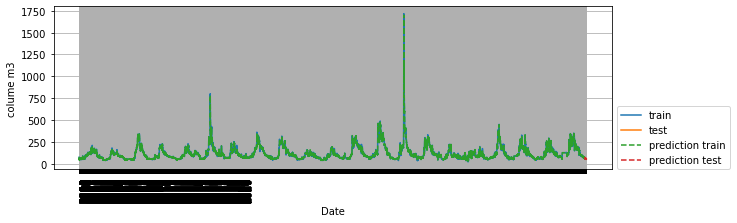

In [9]:
eval_on_features(X, y, regressor)

### 2.2 Multiple lag features

We can use this shifting technique to engineer multiple feature columns, each with a different lag.

One time step is 3 months. We include lags of 1-4 3 months chunks. This would mean that we need one year worth of data to do predictions.